In [1]:
import tensorflow 
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner as kt
tensorflow.keras.utils.set_random_seed(812)

2025-10-17 13:21:36.189302: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-17 13:21:36.230009: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-17 13:21:36.927732: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train_augmentation = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,   
    height_shift_range=0.1 )
train_gen = train_augmentation.flow_from_directory(
         "/home/ocelot/Desktop/CNN_RPS/Archive/train",
        target_size=(100,150),
        batch_size=32,
        class_mode="categorical",
        color_mode="grayscale",
        seed=42

)

val_gen = ImageDataGenerator(rescale = 1./255).flow_from_directory(
     "/home/ocelot/Desktop/CNN_RPS/Archive/validation",
     target_size=(100,150),
     batch_size=32,
     class_mode="categorical",
     color_mode="grayscale",
     seed=42)

    

Found 1531 images belonging to 3 classes.
Found 438 images belonging to 3 classes.


In [3]:
early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)
def create_model(hp):
    model = tensorflow.keras.models.Sequential([
        layer.InputLayer(shape=(100,150,1)),
        layer.Conv2D(hp.Choice('conv_1', [32,64]), (3,3), padding='same'),
        layer.BatchNormalization(), 
        layer.Activation("relu"),
        layer.Conv2D(hp.Choice('conv_1', [32,64]), (3,3), padding='same'),
        layer.BatchNormalization(), 
        layer.Activation("relu"),
        layer.MaxPooling2D((2,2)),
        layer.Conv2D(hp.Choice('conv_2', [64, 128]), (3,3), padding='same'),
        layer.BatchNormalization(), 
        layer.Activation("relu"),
        layer.Conv2D(hp.Choice('conv_2', [64, 128]), (3,3), padding='same'),
        layer.BatchNormalization(), 
        layer.Activation("relu"),
        layer.MaxPooling2D((2,2)),
        layer.Conv2D(hp.Choice('conv_3', [128, 256]), (3,3), padding='same'),
        layer.BatchNormalization(), 
        layer.Activation("relu"),
        layer.Conv2D(hp.Choice('conv_3', [128, 256]), (3,3), padding='same'),
        layer.BatchNormalization(), 
        layer.Activation("relu"),
        layer.MaxPooling2D((2,2)),
        layer.GlobalAveragePooling2D(),      
        layer.Dropout(hp.Float("dropout", min_value=0.25, max_value=0.50, step=0.25)),
        layer.Dense(hp.Choice('num_units', [64, 128, 256]), activation='relu'),
        layer.Dense(3, activation='softmax')])
    optim = tensorflow.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    model.compile(optimizer=optim, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [4]:
tuner = kt.RandomSearch(
    create_model, 
    objective='val_accuracy',  
    max_trials=25,  
    executions_per_trial=3,  
    directory='/home/ocelot/Desktop', 
    project_name='cnn_tuning'  
)

I0000 00:00:1760700100.509454  228352 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13390 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
result= tuner.search(train_gen,  
             epochs=20,
             validation_data=val_gen)

Trial 25 Complete [00h 01m 28s]
val_accuracy: 0.9840182662010193

Best val_accuracy So Far: 0.9908675750096639
Total elapsed time: 00h 40m 07s


In [6]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
for param, value in best_hps.values.items():
    print(f"  {param}: {value}")

  conv_1: 64
  conv_2: 128
  conv_3: 256
  dropout: 0.25
  num_units: 64
  learning_rate: 0.00012227914055837984


In [7]:
best_model = create_model(best_hps)

In [8]:
test_gen = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    "/home/ocelot/Desktop/CNN_RPS/Archive/test",
     target_size=(100,150),
     batch_size=32,
     class_mode="categorical",
     color_mode="grayscale",
     shuffle=False,
     seed=42)

Found 219 images belonging to 3 classes.


In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)
history= best_model.fit(train_gen, epochs=50, callbacks=[early_stop,lr_scheduler], validation_data=val_gen)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.8295 - loss: 0.5082 - val_accuracy: 0.3311 - val_loss: 1.1929 - learning_rate: 1.2228e-04
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9608 - loss: 0.1734 - val_accuracy: 0.3311 - val_loss: 1.4706 - learning_rate: 1.2228e-04
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9706 - loss: 0.1368 - val_accuracy: 0.3311 - val_loss: 1.7387 - learning_rate: 1.2228e-04
Epoch 4/50
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9784 - loss: 0.1121
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.113957351772115e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9771 - loss: 0.1023 - val_accuracy: 0.3311 - val_loss: 2.1257 - learning_rate: 1.2228e-04
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9778 - loss: 0.0891 - val_accuracy: 0.3311 - val_loss: 2.4767 - learning_rate: 6.1140e-05
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9856 - los

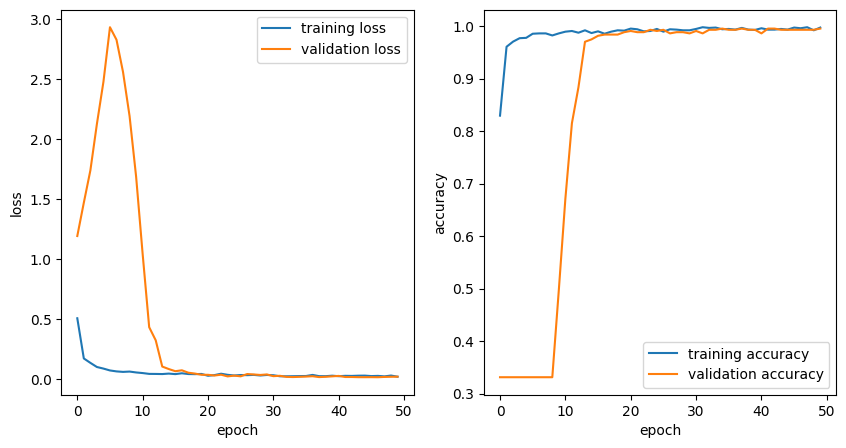

In [10]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
ax[0].plot(history.history["loss"], label="training loss")
ax[0].plot(history.history["val_loss"], label="validation loss")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[1].plot(history.history["accuracy"], label="training accuracy")
ax[1].plot(history.history["val_accuracy"], label="validation accuracy")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend()

In [11]:
testLoss, testAccuracy = best_model.evaluate(test_gen)

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9688 - loss: 0.0477

2025-10-17 14:04:38.681495: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-17 14:04:38.961679: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_259', 8 bytes spill stores, 8 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9954 - loss: 0.0119


In [12]:
import numpy as np
from sklearn.metrics import classification_report
pred = best_model.predict(test_gen)
pred = np.argmax(pred, axis=1)
real_label = test_gen.classes
keys = test_gen.class_indices.keys()
keys = list(keys)
report = classification_report(real_label, pred, target_names=keys, output_dict=True)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


In [13]:
report["scissors"]

{'precision': 0.9868421052631579,
 'recall': 1.0,
 'f1-score': 0.9933774834437086,
 'support': 75.0}

In [14]:
report["rock"]

{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 73.0}

In [15]:
report["paper"]

{'precision': 1.0,
 'recall': 0.9859154929577465,
 'f1-score': 0.9929078014184397,
 'support': 71.0}

Label predetta: scissors Label vera: paper


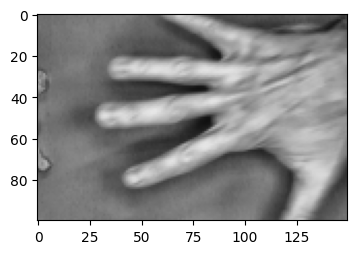

In [16]:
import cv2
errori_indice=[]
for i in range(len(real_label)):
    if real_label[i] != pred[i]:
        errori_indice.append(i)
file = test_gen.filepaths
errori = {"immagini":[], "LabelGiusta":[], "LabelPred":[]}
for i in errori_indice:
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(cv2.imread(file[i]), cv2.COLOR_BGR2RGB))
    print("Label predetta: {} Label vera: {}".format(keys[pred[i]], keys[real_label[i]]))

In [17]:
best_model.save("/home/ocelot/Desktop/terzo_def.keras")